In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import cv2
import os
import librosa
import librosa.display
from scipy import signal
from tqdm import tqdm
import concurrent.futures
import os

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d shayanfazeli/heartbeat

 94% 93.0M/98.8M [00:01<00:00, 55.8MB/s]
100% 98.8M/98.8M [00:01<00:00, 62.1MB/s]


In [5]:
import zipfile
zf = "/content/heartbeat.zip"
target_dir = "/content/dataset/mitbih-database"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [6]:
train = pd.read_csv('/content/dataset/mitbih-database/mitbih_train.csv',header=None).astype(np.float32)
test = pd.read_csv('/content/dataset/mitbih-database/mitbih_test.csv',header=None).astype(np.float32)

In [ ]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890356,0.758160,0.423974,0.219104,0.201128,0.210400,0.205808,0.201773,0.198692,0.196757,0.198779,0.203551,0.208776,0.212885,0.218393,0.224967,0.231379,0.237125,0.242582,0.247923,0.253751,0.259748,0.266245,0.272733,0.279354,0.285588,0.291808,0.297672,0.303384,0.308793,0.313893,0.318457,0.322086,0.324891,0.326734,0.327816,0.327930,0.326746,0.324325,0.320536,...,0.030729,0.029582,0.028531,0.027573,0.026875,0.025771,0.024823,0.023932,0.023060,0.022458,0.021809,0.021245,0.020623,0.020026,0.019534,0.019053,0.018592,0.017664,0.016740,0.015722,0.014402,0.013024,0.011625,0.010262,0.008929,0.008056,0.007278,0.006531,0.005981,0.005479,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240888,0.221814,0.227304,0.206878,0.177056,0.171909,0.178480,0.177242,0.171778,0.168357,0.171796,0.176496,0.180276,0.184101,0.186961,0.190001,0.193898,0.198464,0.202855,0.207166,0.211186,0.214820,0.218448,0.221486,0.224031,0.225848,0.227133,0.227828,0.228436,0.228871,0.228760,0.228392,0.227472,0.226179,0.224658,0.223108,0.221350,0.219258,0.216883,0.214167,...,0.116490,0.114428,0.112680,0.111051,0.110542,0.108570,0.106472,0.104562,0.102671,0.101389,0.100239,0.099363,0.098335,0.096661,0.095734,0.095383,0.095070,0.092874,0.091131,0.088560,0.084640,0.079984,0.075278,0.069872,0.063992,0.060067,0.056399,0.052856,0.050005,0.046697,0.044163,0.042087,0.040523,0.038648,0.037200,0.036258,0.034781,0.032867,0.031921,1.143108
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,0.070543,0.069182,0.068293,0.067744,0.070175,0.072993,0.074803,0.075972,0.076923,0.077872,0.079442,0.081911,0.085938,0.090032,0.094595,0.098901,0.103960,0.109348,0.114754,0.120730,0.127946,0.135962,0.144295,0.151852,0.157895,0.161035,0.161133,0.159383,0.157343,0.155388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

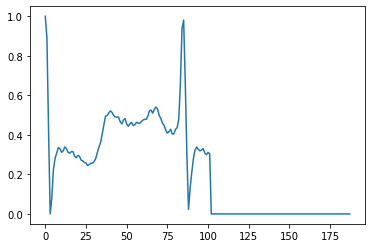

In [ ]:
x = train.iloc[30,:].values
plt.plot(x)
plt.show()

In [ ]:
sos = signal.butter(5, 25, 'lp', fs=125, output='sos')
filtered = signal.sosfilt(sos, x)

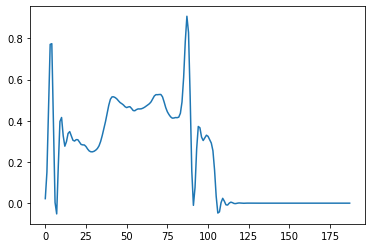

In [ ]:
plt.plot(filtered)
plt.show()

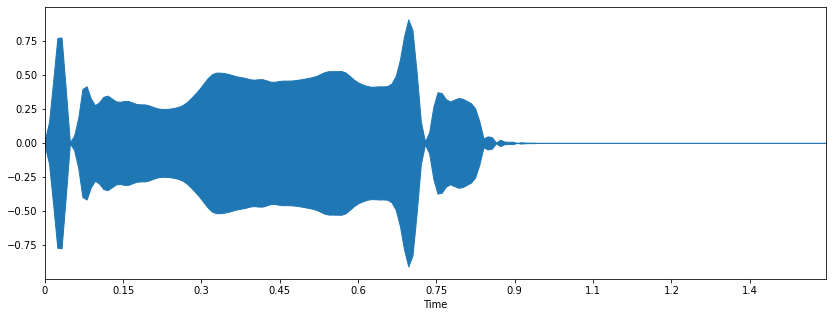

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(filtered, sr=125)

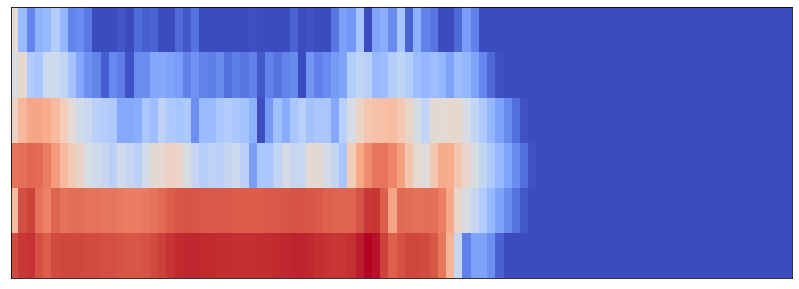

In [ ]:
X = librosa.stft(filtered,n_fft=10)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=125)

## Saving the Dataset

In [ ]:
def save_sample(x, save_path):
    sos = signal.butter(5, 25, 'lp', fs=125, output='sos')
    filtered = signal.sosfilt(sos, x)   
    X = librosa.stft(filtered,n_fft=10)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=125)
    plt.savefig(save_path, bbox_inches='tight')
    plt.close()

In [ ]:
datadir = "/content/mitbih/test/"

In [ ]:
# replaced the slower if statements
lbl_dict = {0.0: 'normal/',
            1.0: 'sve/',
            2.0: 've/',
            3.0: 'fb/',
            4.0: 'ub/'}

In [ ]:
!mkdir -p $datadir/normal
!mkdir $datadir/sve
!mkdir $datadir/ve
!mkdir $datadir/fb
!mkdir $datadir/ub

In [ ]:
#with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
for i in tqdm(range(test.shape[0])):
    sample = test.iloc[i,:-1]
    save_path = datadir+lbl_dict[test.iloc[i,-1]]+str(i)+'.jpg'
    #print(save_path)
    if not os.path.exists(save_path):
        save_sample(sample, save_path)

100%|██████████| 21892/21892 [07:02<00:00, 51.77it/s]


In [ ]:
!zip -q -r /content/drive/MyDrive/mitbih_spectrogram_test.zip mitbih/test/

In [ ]:
datadir = "/content/mitbih/train/"

In [ ]:
!mkdir -p $datadir/normal
!mkdir $datadir/sve
!mkdir $datadir/ve
!mkdir $datadir/fb
!mkdir $datadir/ub

In [ ]:
lbl_dict = {0.0: 'normal/',
            1.0: 'sve/',
            2.0: 've/',
            3.0: 'fb/',
            4.0: 'ub/'}

In [ ]:
for i in tqdm(range(train.shape[0])):
    sample = train.iloc[i,:-1]
    save_path = datadir+lbl_dict[train.iloc[i,-1]]+str(i)+'.jpg'
    if not os.path.exists(save_path):
        save_sample(sample, save_path)

100%|██████████| 87554/87554 [08:55<00:00, 163.41it/s]


In [ ]:
!zip -q -r /content/drive/MyDrive/mitbih_spectrogram_train.zip mitbih/train/

In [ ]:
import gc

## Creating the Model

In [ ]:
batch_size = 512

In [ ]:
import zipfile
zf = "/content/drive/MyDrive/mitbih_spectrogram_train.zip"
target_dir = "/content/"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
zf = "/content/drive/MyDrive/mitbih_spectrogram_test.zip"
target_dir = "/content/"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory('/content/mitbih/train',target_size=(128,128),batch_size=batch_size,
                                                    class_mode='categorical')

Found 87554 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = train_datagen.flow_from_directory('/content/mitbih/test',target_size=(128,128),batch_size=21892,
                                                    class_mode='categorical',shuffle=False)

Found 21892 images belonging to 5 classes.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import resample
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, MaxPooling2D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, Add, ReLU, Conv2D, BatchNormalization, Flatten, SeparableConv2D
from sklearn.metrics import f1_score, accuracy_score
import keras
from keras.models import Sequential

In [ ]:
model = Sequential()

model.add(SeparableConv2D(32,(3,3),input_shape=(128,128,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(SeparableConv2D(32,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(SeparableConv2D(64,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(SeparableConv2D(64,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(SeparableConv2D(128,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(SeparableConv2D(128,(3,3),kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(keras.layers.ELU())

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128,activation='relu'))

# model.add(keras.layers.ELU())

model.add(BatchNormalization())

model.add(Dense(64,activation='relu'))

model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(activation='softmax',units=5))

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 126, 126, 32)      155       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
elu (ELU)                    (None, 126, 126, 32)      0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 124, 124, 32)      1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
elu_1 (ELU)                  (None, 124, 124, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    epochs=25)

Epoch 1/25
171/171 [==============================] - 325s 2s/step - loss: 1.0145 - accuracy: 0.6864
Epoch 2/25
171/171 [==============================] - 295s 2s/step - loss: 0.1481 - accuracy: 0.9666
Epoch 3/25
171/171 [==============================] - 298s 2s/step - loss: 0.1097 - accuracy: 0.9722
Epoch 4/25
171/171 [==============================] - 297s 2s/step - loss: 0.1491 - accuracy: 0.9614
Epoch 5/25
171/171 [==============================] - 297s 2s/step - loss: 0.0926 - accuracy: 0.9757
Epoch 6/25
171/171 [==============================] - 297s 2s/step - loss: 0.0738 - accuracy: 0.9806
Epoch 7/25
171/171 [==============================] - 294s 2s/step - loss: 0.0617 - accuracy: 0.9831
Epoch 8/25
171/171 [==============================] - 294s 2s/step - loss: 0.0515 - accuracy: 0.9857
Epoch 9/25
171/171 [==============================] - 294s 2s/step - loss: 0.0466 - accuracy: 0.9867
Epoch 10/25
171/171 [==============================] - 293s 2s/step - loss: 0.0433 - accura

In [ ]:
model.save("/content/drive/MyDrive/ECG_Model.h5")

In [ ]:
test_accu = model.evaluate(test_generator)
print('The testing accuracy is - ',test_accu[1]*100,'%')

KeyboardInterrupt: ignored

In [ ]:
X,y = test_generator.next()

In [ ]:
from keras.utils import np_utils

In [ ]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss, precision_score, recall_score

y_bar = np.round(model.predict(X))
y_act = y

##accuracy
print("Accuracy: ",accuracy_score(y_bar,y_act))
##F1-Score Score
print("F1 score: ",f1_score(y_bar,y_act,average='macro'))
##Precision score
print("Precision: ",precision_score(y_bar,y_act,average='macro'))
##Recall score
print("Recall: ",recall_score(y_bar,y_act,average='macro'))

Accuracy:  0.9773433217613741
F1 score:  0.8763449272299185
Precision:  0.8264229886312998
Recall:  0.9473790443096852


In [8]:
import cv2
import os
import librosa
import librosa.display
from scipy import signal

def converttoSpectrogram(x):
    sos = signal.butter(5, 25, 'lp', fs=125, output='sos')
    filtered = signal.sosfilt(sos, x)   
    X = librosa.stft(filtered,n_fft=10)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(Xdb, sr=125)
    plt.savefig('temp.jpg', bbox_inches='tight')
    plt.close()

    #loading 
    image = cv2.imread('temp.jpg')[:,:,[2,1,0]]
    os.remove('temp.jpg')
    return cv2.resize(image,(128,128))

In [9]:
temp = train.iloc[30,:-1].values

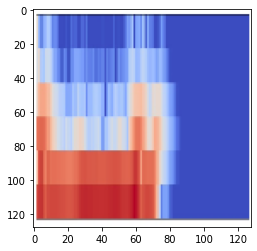

In [10]:
plt.imshow(converttoSpectrogram(temp))

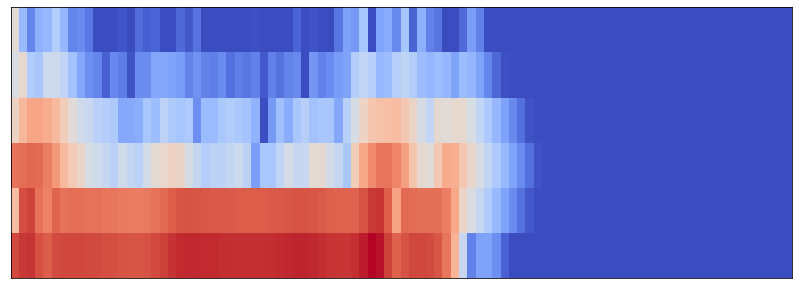

In [11]:
sos = signal.butter(5, 25, 'lp', fs=125, output='sos')
filtered = signal.sosfilt(sos, temp)   
X = librosa.stft(filtered,n_fft=10)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
fig = librosa.display.specshow(Xdb, sr=125)